### Table of contents:

* [Upload useful data](#upload)
* [Investments](#investments)
* [Funding rounds](#fun_rounds)
* [Merge investments and funding rounds](#merge)
* [Graph](#graph)
* [Analysis](#analysis)
* [Update dictionaries](#update)
* [Quick loop](#loop)

In [1]:
import math
import pandas as pd
import arrow
import ipynb 
import pickle
import os.path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from networkx.algorithms import bipartite
from importlib import reload

load_dotenv(verbose=True)


import pandas as pd
pd.options.mode.chained_assignment = None  

In [2]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from functions.fun import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict
from functions.fun import extract_classes_company_tech, degree_bip, insert_data_classes

In [3]:
# import classes 
import classes

## Investments <a class="anchor" id="investments"></a>

In [4]:
df_investments = pd.read_csv("data/data_cb/investments.csv")

In [5]:
df_investments.columns

Index(['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at',
       'updated_at', 'funding_round_uuid', 'funding_round_name',
       'investor_uuid', 'investor_name', 'investor_type', 'is_lead_investor'],
      dtype='object')

**Data Cleaning**

In [6]:
to_drop = [
    'uuid',
    'permalink',
    'funding_round_name',
    'cb_url',
    'created_at',
    'updated_at',   
    'rank',
    'created_at',
    'updated_at'
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = {  }

drop_if_nan = [

]

to_check_double = {}

sort_by = ""

In [7]:
df_investments = CB_data_cleaning(df_investments, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [8]:
df_investments.head()

,name,type,funding_round_uuid,investor_uuid,investor_name,investor_type,is_lead_investor
0,Accel investment in Series A - Facebook,investment,d950d7a5-79ff-fb93-ca87-13386b0e2feb,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,organization,True
1,Greylock investment in Series B - Facebook,investment,6fae3958-a001-27c0-fb7e-666266aedd78,e2006571-6b7a-e477-002a-f7014f48a7e3,Greylock,organization,True
2,Meritech Capital Partners investment in Series...,investment,6fae3958-a001-27c0-fb7e-666266aedd78,8d5c7e48-82da-3025-dd46-346a31bab86f,Meritech Capital Partners,organization,True
3,Trinity Ventures investment in Series B - Phot...,investment,bcd5a63d-ed99-6963-0dd2-e36f6582f846,7ca12f7a-2f8e-48b4-a8d1-1a33a0e275b9,Trinity Ventures,organization,NaN
4,Founders Fund investment in Series A - Geni,investment,60e6afd9-1215-465a-dd17-0ed600d4e29b,fb2f8884-ec07-895a-48d7-d9a9d4d7175c,Founders Fund,organization,True


In [9]:
df_investments.loc[0]

name                  Accel investment in Series A - Facebook
type                                               investment
funding_round_uuid       d950d7a5-79ff-fb93-ca87-13386b0e2feb
investor_uuid            b08efc27-da40-505a-6f9d-c9e14247bf36
investor_name                                           Accel
investor_type                                    organization
is_lead_investor                                         True
Name: 0, dtype: object

## Funding rounds <a class="anchor" id="fun_rounds"></a>

In [10]:
df_funding = pd.read_csv("data/data_cb/funding_rounds.csv")

In [11]:
to_drop = [
    'type',
    'permalink',
    'cb_url',   
    'rank',
    'funding_round_name',
    'created_at',
    'updated_at',
    'investor_type',
    'raised_amount',
    'is_lead_investor',
    'post_money_valuation_usd',                                      
    'post_money_valuation',                                    
    'post_money_valuation_currency_code',
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = { 'category_list': 'category_groups', 'uuid':'funding_round_uuid' }

drop_if_nan = [
    'name'
]

to_check_double = {}

sort_by = ""

In [12]:
df_funding = CB_data_cleaning(df_funding, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [13]:
df_funding.head()


,funding_round_uuid,name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount_currency_code,investor_count,org_uuid,org_name,lead_investor_uuids
0,8a945939-18e0-cc9d-27b9-bf33817b2818,Angel Round - Facebook,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,3f47be49-2e32-8118-01a0-31685a4d0fd7
1,d950d7a5-79ff-fb93-ca87-13386b0e2feb,Series A - Facebook,USA,CA,California,Menlo Park,series_a,2005-05-01,12700000.0,USD,4.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,b08efc27-da40-505a-6f9d-c9e14247bf36
2,6fae3958-a001-27c0-fb7e-666266aedd78,Series B - Facebook,USA,CA,California,Menlo Park,series_b,2006-04-01,27500000.0,USD,5.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,"e2006571-6b7a-e477-002a-f7014f48a7e3,8d5c7e48-..."
3,bcd5a63d-ed99-6963-0dd2-e36f6582f846,Series B - Photobucket,USA,CO,Colorado,Denver,series_b,2006-05-01,10500000.0,USD,2.0,f53cb4de-236e-0b1b-dee8-7104a8b018f9,Photobucket,NaN
4,60e6afd9-1215-465a-dd17-0ed600d4e29b,Series A - Geni,USA,CA,California,West Hollywood,series_a,2007-01-17,NaN,NaN,1.0,4111dc8b-c0df-2d24-ed33-30cd137b3098,Geni,fb2f8884-ec07-895a-48d7-d9a9d4d7175c


In [14]:
df_funding.loc[0]

funding_round_uuid             8a945939-18e0-cc9d-27b9-bf33817b2818
name                                         Angel Round - Facebook
country_code                                                    USA
state_code                                                       CA
region                                                   California
city                                                     Menlo Park
investment_type                                               angel
announced_on                                             2004-09-01
raised_amount_usd                                          500000.0
raised_amount_currency_code                                     USD
investor_count                                                  4.0
org_uuid                       df662812-7f97-0b43-9d3e-12f64f504fbb
org_name                                                   Facebook
lead_investor_uuids            3f47be49-2e32-8118-01a0-31685a4d0fd7
Name: 0, dtype: object

## Merge investments and funding rounds <a class="anchor" id="merge"></a>

The two datasets invetsments and funding rounds must be matched in order to have infomrations about the investments and the amount of the invetsments (contained only in the funding rounds dataset)

In [15]:
# merge df_funding and df_investments accoridng to the column funding_round_uuid
df_invest_funding_start = pd.merge(df_funding, df_investments, on='funding_round_uuid')

In [16]:
to_drop = [
    'funding_round_uuid',
    'name_x',
    'org_uuid',   
    'lead_investor_uuids',
    'name_y',
    'investor_uuid',
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = {  }
drop_if_nan = []
to_check_double = {}
sort_by = ""

In [17]:
df_invest_funding = CB_data_cleaning(df_invest_funding_start, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [18]:
df_invest_funding.head()

,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount_currency_code,investor_count,org_name,type,investor_name,investor_type,is_lead_investor
0,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Peter Thiel,person,True
1,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Reid Hoffman,person,False
2,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Mark Pincus,person,False
3,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Western Technology Investment,organization,False
4,USA,CA,California,Menlo Park,series_a,2005-05-01,12700000.0,USD,4.0,Facebook,investment,Accel,organization,True


In [19]:
len(df_invest_funding)

624040

### Graph  <a class="anchor" id="graph"></a>

In [20]:
df_graph = df_invest_funding[["org_name", "investor_name"]]
df_graph = df_graph.set_index("org_name")
df_graph.head()

,investor_name
org_name,
Facebook,Peter Thiel
Facebook,Reid Hoffman
Facebook,Mark Pincus
Facebook,Western Technology Investment
Facebook,Accel


In [21]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict, df_from_api_CB, extract_nodes

In [22]:
# set limit
df_graph = df_graph[:100]

In [23]:
# create the bipartite network

B = nx_dip_graph_from_pandas(df_graph)

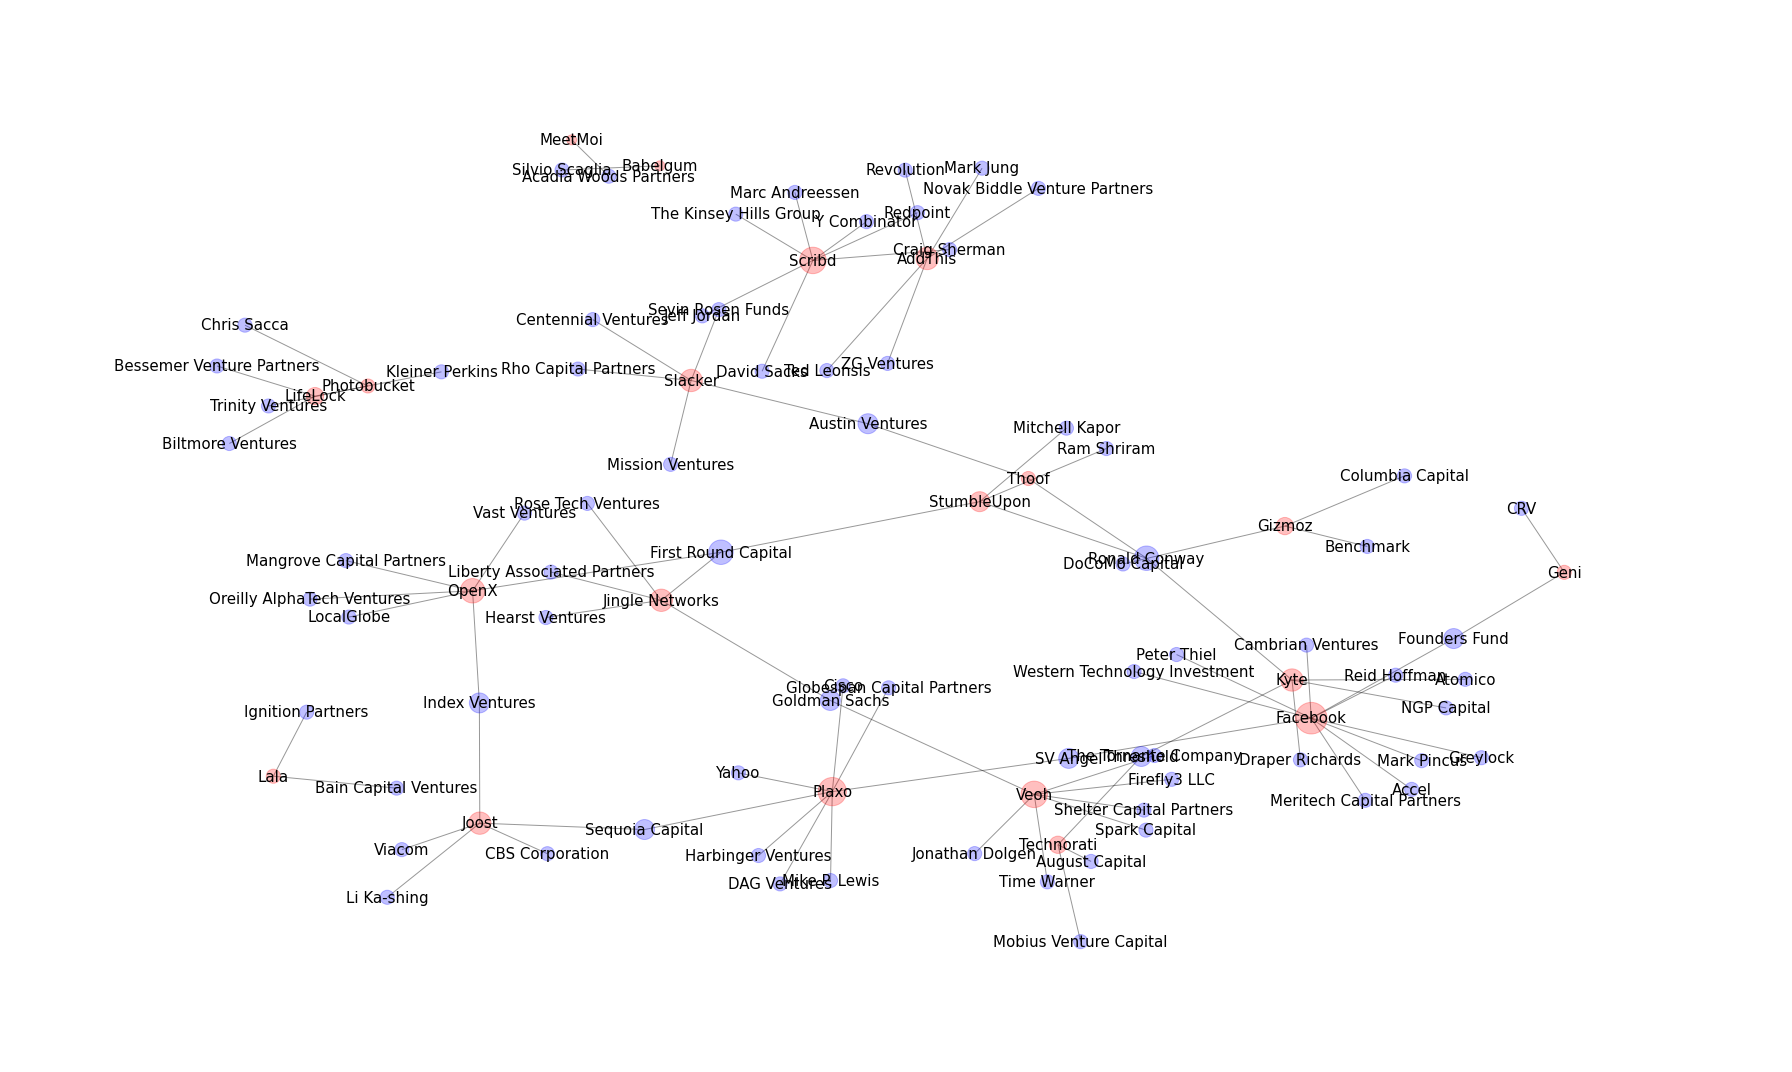

In [24]:
pos = plot_bipartite_graph(B, small_degree=True)

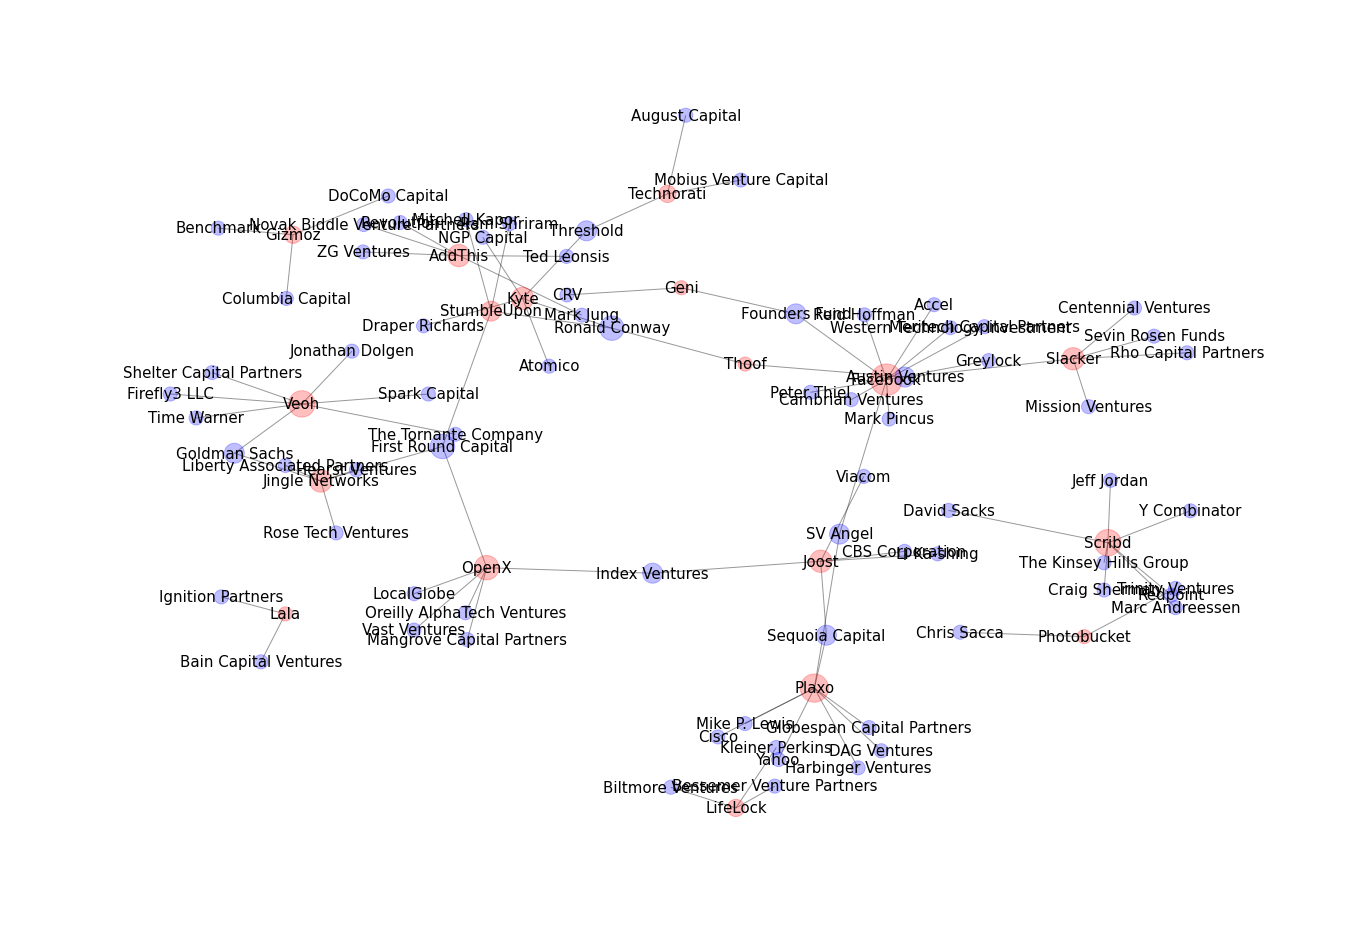

In [25]:
pos = plot_bipartite_graph(B, small_degree=False)

### Upload useful data <a class="anchor" id="upload"></a>

In [26]:
num_comp = 100
num_tech = 131

In [27]:
name_file_com = f'savings/classes/dict_companies_cybersecurity_{num_comp}.pickle'
name_file_tech = f'savings/classes/dict_tech_cybersecurity_{num_tech}.pickle'
name_file_graph = f'savings/networks/cybersecurity_comp_{num_comp}_tech_{num_tech}.gpickle'

In [28]:
with open(name_file_com, 'rb') as f:
    dict_companies = pickle.load(f)
B_com_tech = nx.read_gpickle(name_file_graph)

In [29]:
name_file_tech = "savings/classes/dict_tech_cybersecurity_26.pickle"
with open(name_file_tech, 'rb') as f:
    dict_tech = pickle.load(f)
    

### Clean: only companies in dict_companies

In [30]:
df_invest_funding_cleaned = df_invest_funding[df_invest_funding['org_name'].isin(list(dict_companies.keys()))]

In [31]:
len(df_invest_funding_cleaned)

882

In [32]:
df_invest_funding_cleaned.head()

,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount_currency_code,investor_count,org_name,type,investor_name,investor_type,is_lead_investor
3197,USA,VA,Virginia,Mclean,angel,2006-12-01,NaN,NaN,3.0,Cricket Media,investment,Yossi Vardi,person,NaN
3198,USA,VA,Virginia,Mclean,angel,2006-12-01,NaN,NaN,3.0,Cricket Media,investment,Mitchell Kapor,person,NaN
3199,USA,VA,Virginia,Mclean,angel,2006-12-01,NaN,NaN,3.0,Cricket Media,investment,Steve Case,person,NaN
3200,USA,VA,Virginia,Mclean,series_a,2008-02-01,NaN,NaN,1.0,Cricket Media,investment,National Geographic,organization,True
4596,USA,CA,California,Redwood City,series_b,2007-07-16,3500000.0,USD,2.0,Talend,investment,Galileo Partners,organization,NaN


## Analysis <a class="anchor" id="analysis"></a>

In [33]:
df_essential = df_invest_funding_cleaned[["org_name", "investor_name", "raised_amount_usd"]]
df_essential.head()

,org_name,investor_name,raised_amount_usd
3197,Cricket Media,Yossi Vardi,NaN
3198,Cricket Media,Mitchell Kapor,NaN
3199,Cricket Media,Steve Case,NaN
3200,Cricket Media,National Geographic,NaN
4596,Talend,Galileo Partners,3500000.0


In [34]:
# delete value with NaN investments

df_essential.dropna(subset = ["raised_amount_usd"], inplace=True)

df_essential.head()

,org_name,investor_name,raised_amount_usd
4596,Talend,Galileo Partners,3500000.0
4597,Talend,Idinvest Partners,3500000.0
4907,Acronis,OpenView,11000000.0
4908,Acronis,Insight Partners,11000000.0
4909,Acronis,ABRT,11000000.0


In [35]:
len(df_essential)

814

In [36]:
# total amount of investments for each company

df_tot_inves_per_company = df_essential.groupby("org_name").sum()
df_tot_inves_per_company = df_tot_inves_per_company.sort_values("raised_amount_usd", ascending=False)
df_tot_inves_per_company.head()

,raised_amount_usd
org_name,
FirstEnergy Corp.,1.000000e+10
Lacework,5.087000e+09
LianBio,4.650000e+09
Telegram Messenger,2.000000e+09
OneTrust,1.940000e+09


In [37]:
# total amount of investments for each investors

df_tot_inves_per_investor = df_essential.groupby("investor_name").sum()
df_tot_inves_per_investor = df_tot_inves_per_investor.sort_values("raised_amount_usd", ascending=False)
df_tot_inves_per_investor.head()

,raised_amount_usd
investor_name,
Bluescape,2.500000e+09
Zimmer Lucas Partners,2.500000e+09
Elliott Management Corp.,2.500000e+09
GIC,2.500000e+09
Coatue,1.035000e+09


In [38]:
# number of investments for each company

df_num_inves_per_company = df_essential[["org_name", "investor_name"]].groupby("org_name").count()
df_num_inves_per_company = df_num_inves_per_company.sort_values("investor_name", ascending=False)
df_num_inves_per_company = df_num_inves_per_company.rename(columns={"investor_name":"number_inv_rounds"})
df_num_inves_per_company.head()

,number_inv_rounds
org_name,
BlackDuck,47
Front Range Biosciences,46
Synack,39
BigID,35
Immuta,33


In [39]:
# number of investments for each investors

df_num_inves_per_investor = df_essential[["org_name", "investor_name"]].groupby("investor_name").count()
df_num_inves_per_investor = df_num_inves_per_investor.sort_values("org_name", ascending=False)
df_num_inves_per_investor = df_num_inves_per_investor.rename(columns={"org_name":"number_investments"})
df_num_inves_per_investor.head()

,number_investments
investor_name,
Intel Capital,17
Kleiner Perkins,9
Sutter Hill Ventures,8
ClearSky,8
Insight Partners,8


**Total investments for technology**

In [40]:
# add column list technologies for each company
df = df_tot_inves_per_company
comp_tech_dict = {name: c.technologies for name,c in dict_companies.items()}
df['technologies'] = [comp_tech_dict[comp_name] for comp_name in df_tot_inves_per_company.index]

In [41]:
df.head()

,raised_amount_usd,technologies
org_name,,
FirstEnergy Corp.,1.000000e+10,"[Clean Energy, Energy, Energy Efficiency, Info..."
Lacework,5.087000e+09,"[Cloud Security, Compliance, Security, Software]"
LianBio,4.650000e+09,"[Biopharma, Biotechnology, Pharmaceutical]"
Telegram Messenger,2.000000e+09,"[Apps, Messaging, Mobile, Mobile Apps, Social ..."
OneTrust,1.940000e+09,"[Compliance, Privacy, Risk Management, Software]"


In [42]:
list_tech =  [item for sublist in df['technologies'] for item in sublist] # list of all technolgies
list_tech = set(list_tech) # unique

df_tot_inves_per_tech = pd.DataFrame(index = list_tech)
sum_inv_tech = [] # list: each elements is the sum of all investments in that tech

for tech in df_tot_inves_per_tech.index:   
    inv_tech = [row['raised_amount_usd'] for index, row in df.iterrows() if tech in row['technologies']]
    
    sum_inv_tech.append(sum(inv_tech))
    
df_tot_inves_per_tech['tot_inv'] = sum_inv_tech

In [43]:
df_tot_inves_per_tech.head()

,tot_inv
Open Source,1.476531e+09
National Security,2.024179e+07
Industrial Automation,1.570000e+08
Blockchain,4.897380e+08
Analytics,1.476024e+09


In [44]:
df_tot_inves_per_tech.index

Index(['Open Source', 'National Security', 'Industrial Automation',
       'Blockchain', 'Analytics', 'Information Technology', 'Retail',
       'Clean Energy', 'Mobile Devices', 'Biotechnology',
       ...
       'Insurance', 'Consumer Goods', 'Scheduling', 'Mobile', 'Aerospace',
       'Enterprise Software', 'IT Infrastructure', 'Agriculture',
       'Marketing Automation', 'Manufacturing'],
      dtype='object', length=119)

## Update dictionaries  <a class="anchor" id="update"></a>

Please note that this step does not work if we haven't first run the main.ipynb file. ALso, remember that the filename is correct 

In [45]:
# company
for name, c in dict_companies.items():
    
    # number previous investments
    if name in df_num_inves_per_company.index:
        num_previous_investments = df_num_inves_per_company.loc[name]['number_inv_rounds']
        
    # total amount previous investments
    if name in df_tot_inves_per_company.index:
        tot_previous_investments = df_tot_inves_per_company.loc[name]['raised_amount_usd']
        
    # update dict_companies
    dict_companies[name].num_previous_investments = num_previous_investments
    dict_companies[name].tot_previous_investments = tot_previous_investments

In [46]:
# technology
for name, c in dict_tech.items():
        
    # total amount previous investments
    if name in df_tot_inves_per_tech.index:
        tot_previous_investments = df_tot_inves_per_tech.loc[name]['tot_inv']
        
    # update dict_companies
    dict_tech[name].tot_previous_investments = tot_previous_investments

In [47]:
# save dictionaries

# companies
with open(name_file_com, "wb") as f:
    pickle.dump(dict_companies, f)

# technologies
with open(name_file_tech, "wb") as f:
    pickle.dump(dict_tech, f)

## Quick loop  <a class="anchor" id="loop"></a>

With quick loop, we mean that we do all the step of the previous sections, in order to update the dictionaries, for all size, in only one loop.

In this part, you won't see many comments because everything has been already explained before :)

In [62]:
size_comp = [10, 100, 500, 1000, 1499, 1999, 2442]
size_tech = [26, 131, 305, 384, 431, 456, 478]

In [70]:
for i in range(len(size_comp)):
    num_comp = size_comp[i]
    num_tech = size_tech[i]
    
    print(num_comp, num_tech)
    
    name_file_com = f'savings/classes/dict_companies_cybersecurity_{num_comp}.pickle'
    name_file_tech = f'savings/classes/dict_tech_cybersecurity_{num_tech}.pickle'
    name_file_graph = f'savings/networks/cybersecurity_comp_{num_comp}_tech_{num_tech}.gpickle'
    
    with open(name_file_com, 'rb') as f:
        dict_companies = pickle.load(f)
    B_com_tech = nx.read_gpickle(name_file_graph)

    with open(name_file_tech, 'rb') as f:
        dict_tech = pickle.load(f)

    df_invest_funding = df_invest_funding[df_invest_funding['org_name'].isin(list(dict_companies.keys()))]

    df_essential = df_invest_funding[["org_name", "investor_name", "raised_amount_usd"]]
    df_essential.dropna(subset = ["raised_amount_usd"], inplace=True)

    df_tot_inves_per_company = df_essential.groupby("org_name").sum()
    df_tot_inves_per_company = df_tot_inves_per_company.sort_values("raised_amount_usd", ascending=False)

    df_tot_inves_per_investor = df_essential.groupby("investor_name").sum()
    df_tot_inves_per_investor = df_tot_inves_per_investor.sort_values("raised_amount_usd", ascending=False)

    df_num_inves_per_company = df_essential[["org_name", "investor_name"]].groupby("org_name").count()
    df_num_inves_per_company = df_num_inves_per_company.sort_values("investor_name", ascending=False)
    df_num_inves_per_company = df_num_inves_per_company.rename(columns={"investor_name":"number_inv_rounds"})

    df_num_inves_per_investor = df_essential[["org_name", "investor_name"]].groupby("investor_name").count()
    df_num_inves_per_investor = df_num_inves_per_investor.sort_values("org_name", ascending=False)
    df_num_inves_per_investor = df_num_inves_per_investor.rename(columns={"org_name":"number_investments"})

    df = df_tot_inves_per_company
    comp_tech_dict = {name: c.technologies for name,c in dict_companies.items()}
    df['technologies'] = [comp_tech_dict[comp_name] for comp_name in df_tot_inves_per_company.index]

    list_tech =  [item for sublist in df['technologies'] for item in sublist] # list of all technolgies
    list_tech = set(list_tech) # unique

    df_tot_inves_per_tech = pd.DataFrame(index = list_tech)
    sum_inv_tech = [] # list: each elements is the sum of all investments in that tech

    for tech in df_tot_inves_per_tech.index:   
        inv_tech = [row['raised_amount_usd'] for index, row in df.iterrows() if tech in row['technologies']]

        sum_inv_tech.append(sum(inv_tech))

    df_tot_inves_per_tech['tot_inv'] = sum_inv_tech

    for name, c in dict_companies.items():

        # number previous investments
        if name in df_num_inves_per_company.index:
            num_previous_investments = df_num_inves_per_company.loc[name]['number_inv_rounds']

        # total amount previous investments
        if name in df_tot_inves_per_company.index:
            tot_previous_investments = df_tot_inves_per_company.loc[name]['raised_amount_usd']

        # update dict_companies
        dict_companies[name].num_previous_investments = num_previous_investments
        dict_companies[name].tot_previous_investments = tot_previous_investments

    for name, c in dict_tech.items():

        # total amount previous investments
        if name in df_tot_inves_per_tech.index:
            tot_previous_investments = df_tot_inves_per_tech.loc[name]['tot_inv']

        # update dict_companies
        dict_tech[name].tot_previous_investments = tot_previous_investments

    # save dictionaries

    # companies
    with open(name_file_com, "wb") as f:
        pickle.dump(dict_companies, f)

    # technologies
    with open(name_file_tech, "wb") as f:
        pickle.dump(dict_tech, f)

10 26
100 131
500 305
1000 384
1499 431
1999 456
2442 478
